<a href="https://colab.research.google.com/github/votamvan/Movie-Recommendation/blob/master/ML_Project2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS582 Machine Learning - Project 2
Professor: Mohamed Abdelrazik

Team:
*   Tam Van Vo - 610746
*   Quynh Pham - 610716
*   Samsher Bahadur Rana - 611060
*   Van Vong Tran - 610772
*   Yared Geberetsadik Beyene - 110466

Project Colab URL: 

https://colab.research.google.com/drive/1B8HxIE6tlmFq5gLVam4pnLkSSZRThzD0

Dataset: 

https://www.kaggle.com/rounakbanik/the-movies-dataset

Ref:

https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

https://www.ijert.org/research/recommender-systems-types-of-filtering-techniques-IJERTV3IS110197.pdf

https://www.kaggle.com/fabiendaniel/film-recommendation-engine

https://github.com/NicolasHug/Surprise



# Part 1: Recommend top trending movies

**What are top trending movies?**

Recently popular, most watched or widely discussed online, especially on social media websites such as IMDB.

**Data Resource**

Movie metadata from imdb dataset


**What is Demographic Filtering?**

RS based on Demographic filtering (DF) classify users according to their demographic information and recommend services accordingly

**Solution**

By applying the Demographic Filtering technique on imdb dataset we can find the most trending movies which allows finding a score for ranking movies.

Take a look at the dataset we have voting information from the imdb users who watched the movie and shared their opinion. There are 2 values we can use:
**vote_average** - average ratings the movie received
**vote_count** - the count of votes received
We can use IMDB's weighted rating (wr) formula to generate the appropriate way to set the score:


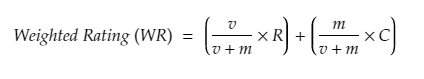

* v is the number of votes for the movie - vote_count 
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie - vote_average 
* C is the mean vote across the whole report



#Load all libs




In [0]:
from random import randrange
import numpy as np
import seaborn as sns
import pandas as pd
import pandas.util.testing as tm
import matplotlib.pyplot as plt
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Dataset - Movie Metadata

In [0]:
df_movies_metadata = pd.read_csv('movies_metadata.csv')
df_movies_metadata.sample(3)

adult belongs_to_collection budget  ...  video vote_average vote_count
37186  False                   NaN      0  ...  False          5.2        6.0
3052   False                   NaN      0  ...  False          6.5       43.0
41510  False                   NaN  11178  ...  False          8.0        1.0

[3 rows x 24 columns]

In [0]:
df_date = df_movies_metadata[['release_date']]
df_date = df_date.sort_values(by='release_date',ascending=False)
df_date.head()

release_date
35586           22
26558   2020-12-16
38884   2018-12-31
30401   2018-11-07
38129   2018-04-25

There is one movie hasn't release comparing to current date. So let's say the dataset for 2018. There is a release date is 22, we may assume the movie will be released in 2022

In [0]:
df_movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45465 entries, 0 to 45464
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45465 non-null  object 
 1   belongs_to_collection  4493 non-null   object 
 2   budget                 45465 non-null  object 
 3   genres                 45465 non-null  object 
 4   homepage               7781 non-null   object 
 5   id                     45465 non-null  object 
 6   imdb_id                45448 non-null  object 
 7   original_language      45454 non-null  object 
 8   original_title         45465 non-null  object 
 9   overview               44511 non-null  object 
 10  popularity             45462 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

We have data size of **45465 x 24**

#Clean movies metadata

In [0]:
print(df_movies_metadata.adult.unique())

['False' 'True'
 ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.'
 ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.']


There are some invalid data here, let's clean it up

In [0]:
df_movies_metadata.drop(df_movies_metadata[(df_movies_metadata['adult'] != 'False') 
                    & (df_movies_metadata['adult'] != 'True')].index, inplace=True)

In [0]:
print(df_movies_metadata.adult.unique())

['False' 'True']


# Handle Null Data

In [0]:
def unique_nullcount(df):
  rows = []
  for (i, j) in df.iteritems(): 
      rows.append([i, df[i].nunique(), df[i].isna().sum()])
  df_null_ct = pd.DataFrame(rows, 
                            columns=["Feature", 
                                   "Unique value",
                                   "Count null"]).sort_values(["Unique value",
                                                               "Count null"], 
                                                              ascending = (True,True))
  pd.set_option('display.max_rows', df_null_ct.shape[0]+1)
  return df_null_ct

def unique_value_list(df,df_train, feature, ct):
  features = df[df[feature] < ct]['Feature']
  for i in features: 
      print(i, df_train[i].unique())

In [0]:
df = unique_nullcount(df_movies_metadata.select_dtypes(include=[np.number]))
print(df[df['Count null']>0])

        Feature  Unique value  Count null
2  vote_average            92           2
1       runtime           353         259
3    vote_count          1820           2
0       revenue          6863           2


In [0]:
df_movies_metadata[df_movies_metadata['vote_count'].isna()]

adult  ... vote_count
29501  False  ...        NaN
35585  False  ...        NaN

[2 rows x 24 columns]

These values are the second half of above invalid records. We can manually fix the error or drop they off the dataset.


In [0]:
df_movies_metadata.drop(df_movies_metadata[df_movies_metadata['vote_count'].isna()].index, 
                        inplace=True)


# Demographic Filtering

We already have **v(vote_count)** and **R (vote_average)**

We will calculate **C** and **m**

In [0]:
movie_watched = df_movies_metadata[['vote_average','vote_count']]
movie_watched.describe()

vote_average    vote_count
count  45461.000000  45461.000000
mean       5.618216    109.894943
...             ...           ...
75%        6.800000     34.000000
max       10.000000  14075.000000

[8 rows x 2 columns]

Take a look at the distribution of vote average

In [0]:
def show_lolipop_graph(values,value_name,labels,label_name,colr,title):
  import seaborn as sns
  my_range=range(1,len(labels)+1)
  plt.hlines(y=my_range, xmin=0, xmax=values, color='skyblue')
  plt.plot(values, my_range, "o")  
  # Add titles and axis names
  plt.yticks(my_range, labels)
  plt.title(title, loc='left')
  plt.xlabel(value_name)
  plt.ylabel(label_name)

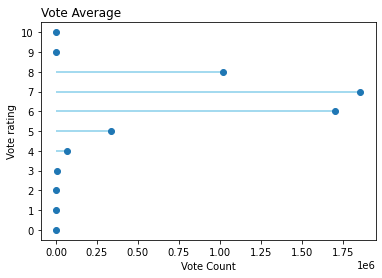

In [0]:
df = movie_watched
import math
df.vote_average = df.vote_average.apply(round)
df.vote_average.unique()
# Reorder it following the values:
df = df.groupby(by='vote_average', as_index=False).agg({'vote_count': sum})
ordered_df = df.sort_values(by='vote_average')

show_lolipop_graph(ordered_df.vote_count, 'Vote Count', ordered_df.vote_average, 
                   'Vote rating', 'skyblue', 'Vote Average')

We can see the higher number of voting have higher distribution from 4 - 8. 

It is understandable because the people who didn't like the movie tend to ignore rating while the people who really love or hate the movie are most likely to give the feedback. So the data is valid and we can perform calculation C and m on this dataset

Let's calculate **C - Mean of vote_average**

In [0]:
C= df_movies_metadata['vote_average'].mean()
C

5.618215613382605

The mean rating for all the movies is about 5.5 on a scale of 10.

The next step is to determine an appropriate value for **m**, the **minimum votes** required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least **90%** of the movies in the list.

In [0]:
m= df_movies_metadata['vote_count'].quantile(0.98)
m

1236.7999999999956

In [0]:
q_movies = df_movies_metadata.copy().loc[df_movies_metadata['vote_count'] >= m]
q_movies.shape

(910, 24)

In [0]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [0]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [0]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)
pd.set_option('display.max_rows', 20)
#Print the top 15 movies
q_movies[['title', 'release_date', 'vote_count', 
          'vote_average', 'score']].head(10)

title  ...     score
314                         The Shawshank Redemption  ...  8.128529
12481                                The Dark Knight  ...  8.054414
834                                    The Godfather  ...  8.009119
2843                                      Fight Club  ...  7.996116
292                                     Pulp Fiction  ...  7.965197
15480                                      Inception  ...  7.899536
351                                     Forrest Gump  ...  7.859717
22878                                   Interstellar  ...  7.852936
7000   The Lord of the Rings: The Return of the King  ...  7.775628
1154                         The Empire Strikes Back  ...  7.758640

[10 rows x 5 columns]

From the result it makes sense because the movie having high review and more watched times will make to top 10. But let's take a look at the release_date. It looks like the older movies have higher chance to be in this list.

# The most popular movies

In the dataset we can find the **popularity** - A numeric quantity specifying the movie popularity. Let's see what are the most popular movies based on this value

Text(0.5, 1.0, 'Popular Movies')

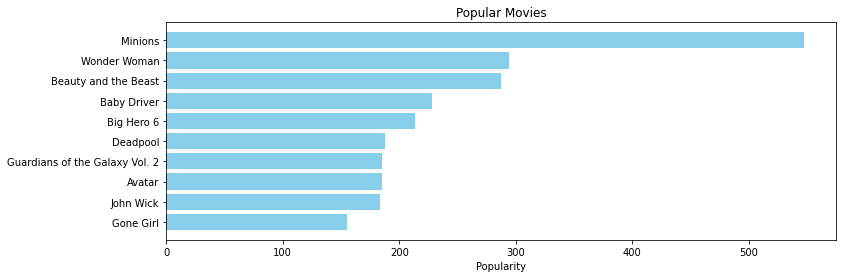

In [0]:
df_movies_metadata.popularity = df_movies_metadata.popularity.apply(float)
pop= df_movies_metadata.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

In [0]:
pop[['title', 'release_date', 'vote_count', 'vote_average','popularity']].head(10)

title release_date  ...  vote_average  popularity
30699                         Minions   2015-06-17  ...           6.4  547.488298
33355                    Wonder Woman   2017-05-30  ...           7.2  294.337037
42221            Beauty and the Beast   2017-03-16  ...           6.8  287.253654
43643                     Baby Driver   2017-06-28  ...           7.2  228.032744
24454                      Big Hero 6   2014-10-24  ...           7.8  213.849907
26563                        Deadpool   2016-02-09  ...           7.4  187.860492
26565  Guardians of the Galaxy Vol. 2   2017-04-19  ...           7.6  185.330992
14551                          Avatar   2009-12-10  ...           7.2  185.070892
24350                       John Wick   2014-10-22  ...           7.0  183.870374
23674                       Gone Girl   2014-10-01  ...           7.9  154.801009

[10 rows x 5 columns]

If we look at this, the date show that these movies are more recent and it has high number of vote_count and vote_average too (higher than mean). **So question is the Demographic Filtering is good enough?**

# Part 2: Recommend similar movies
**What are similar movies?**

The movies have the similar attributes such as: genres, directors, production companies, the main characters, ..etc and especially the contents

**Data Resource**

Movie metadata from imdb dataset
Credits dataset

**What is Content-based Filtering?**

Content-based filtering (CBF) is an outgrowth and continuation of information filtering research. The objects of interest are defined by their associated features in a CBF system. For instance, like the newsgroup filtering system, a text recommendation system, uses the words of their texts as features. Based on the features present in objects that the user has rated, a content-based recommender learns a profile of the user‟s interests which is called as “item-to-item correlation” and it derives the type of user profile depending on the learning method employed.

**Solution**

We are going to apply the technique Content-based filtering on different features of the system



# Movies' description - Plot description based Recommender

Let's find the similar movie based on their description/overview

In [0]:
df_movies_metadata['overview'].head(5)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

We are going to perform text processing by converting the word vector of each overview - computing TF-IDT vectors

**TF-IDF** (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: 

*   How many times a word appears in a document
*   The inverse document frequency of the word across a set of documents.

In [0]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df_movies_metadata['overview'] = df_movies_metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_movies_metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(45461, 75828)

# Cosine Similarity

We see that there are also **76,000** different words were used to describe more than **45000** movies in our dataset.

We will be using the **cosine similarity** to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
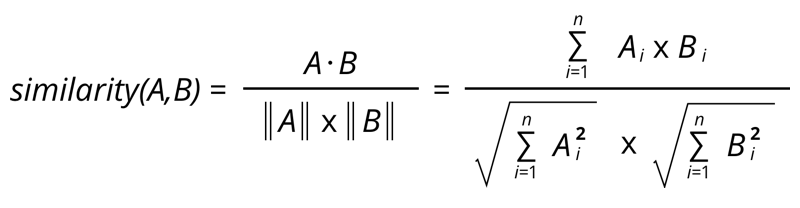

In [0]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. 

Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [0]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df_movies_metadata.index, index=df_movies_metadata['title']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

Get the index of the movie given its title.
Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
Return the titles corresponding to the indices of the top elements.

In [0]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_movies_metadata['title'].iloc[movie_indices]

In [0]:
get_recommendations('Skyfall')

7333         Never Say Never Again
44631                Atomic Blonde
2441        Children of the Damned
43273                   London Spy
36257                      Grimsby
7415     Tinker Tailor Soldier Spy
2833                        Dr. No
18395                      Haywire
30760                      Spectre
34071                 The Diplomat
Name: title, dtype: object

The results show all James Bond movies that makes the function quite impressive. But we should have gotten some similar movie that has Daniel Craig in it also. Let's try to add more features into the recommend system.



# Credits, Genres and Keywords Based Recommender
Let's add more features to see if the result of the similar movies will be better or not

In [0]:
df_credit = pd.read_csv("credits.csv")
df_keyword = pd.read_csv("keywords.csv")
df_movie = df_movies_metadata
df_movie['id'] = df_movie['id'].astype('int')
df_movie = df_movie.merge(df_credit, on='id')
df_movie = df_movie.merge(df_keyword, on='id')
df_movie.head(3)

adult  ...                                           keywords
0  False  ...  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1  False  ...  [{'id': 10090, 'name': 'board game'}, {'id': 1...
2  False  ...  [{'id': 1495, 'name': 'fishing'}, {'id': 12392...

[3 rows x 27 columns]

# Genres

In [0]:
def get_name(g_jason):
  return str(g_jason['name'])

def breaking_value(df, feature):
  from ast import literal_eval
  df[feature] = df[feature].apply(literal_eval)
  df = df.explode(feature)
  df[feature] = df[feature].apply(get_name)
  return df

df_genres = df_movie[['id','title','genres']]
unknown_genres = "[{'id': 0, 'name': 'UnKnown'}]"
df_genres.loc[(df_genres.genres == '[]'),'genres'] = unknown_genres
df_genres = breaking_value(df_genres, 'genres').sort_values(by='genres')
df_genres.head(5)

id                     title  genres
40137  102961                     Seven  Action
18114   85365              Tony Arzenta  Action
18122   58878      Three Outlaw Samurai  Action
18125   39254                Real Steel  Action
18151  133123  The Last Days of Pompeii  Action

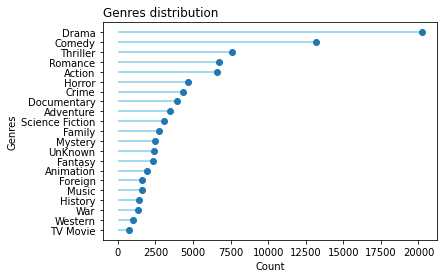

In [0]:
df = df_genres
df = df.groupby(by='genres', as_index=False).agg({'id': pd.Series.nunique})
# Reorder it following the values:
ordered_df = df.sort_values(by='id')

show_lolipop_graph(ordered_df.id, 'Count', ordered_df.genres, 'Genres', 
                   'skyblue', 'Genres distribution')

We can see that the drama movie has the most watched count



# Credits and Keywords

From credits we going the break the **cast**, **keywords** and **crew** data

# General Methods

In [0]:
for key in ['cast', 'crew', 'keywords', 'genres']:
    df_movie[key] = df_movie[key].apply(literal_eval)
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return ''

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3: names = names[:3]
        return names
    return []

df_movie['director'] = df_movie['crew'].apply(get_director)
for col in ['cast', 'keywords', 'genres']:
    df_movie[col] = df_movie[col].apply(get_list)

In [0]:
def word_set(df,ref_col):
  w_set = set()
  for i, row in df.iterrows():
    keys = df[ref_col][i]
    for key in keys:
        w_set.add(key)
  return w_set

def count_word(df, ref_col):
    w_set = word_set(df,ref_col)
    keyword_count = dict()
    for s in w_set: keyword_count[s] = 0
    for i,row in df.iterrows():
      keys = df[ref_col][i]
      for key in keys:       
            keyword_count[key] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences

In [0]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
def show_population(keyword_occurences, type_pt):
  words = dict()
  trunc_occurences = keyword_occurences[0:50]
  for s in trunc_occurences:
      words[s[0]] = s[1]
  tone = 55.0 # define the color of the words
  #WORDCLOUD
  if type_pt == 'WC':
    fig = plt.figure(1, figsize=(18,13))
    ax1 = fig.add_subplot(2,1,1)
    from wordcloud import WordCloud, STOPWORDS
    wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                          max_words=1628,relative_scaling=1,
                          # color_func = random_color_func,
                          colormap="Blues",
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
  if type_pt == 'HG':
    #HISTOGRAMS
    fig = plt.figure(1, figsize=(18,13))
    ax2 = fig.add_subplot(2,1,2)
    y_axis = [i[1] for i in trunc_occurences]
    x_axis = [k for k,i in enumerate(trunc_occurences)]
    x_label = [i[0] for i in trunc_occurences]
    plt.xticks(rotation=85, fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xticks(x_axis, x_label)
    plt.ylabel("Nb. of occurences", fontsize = 15, labelpad = 10)
    ax2.bar(x_axis, y_axis, align = 'center', color='skyblue')
    #_______________________
    plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},
              color='w',fontsize = 18)
    plt.show()

In [0]:
keywords = count_word(df_movie, 'keywords')

# Ploting some graphs

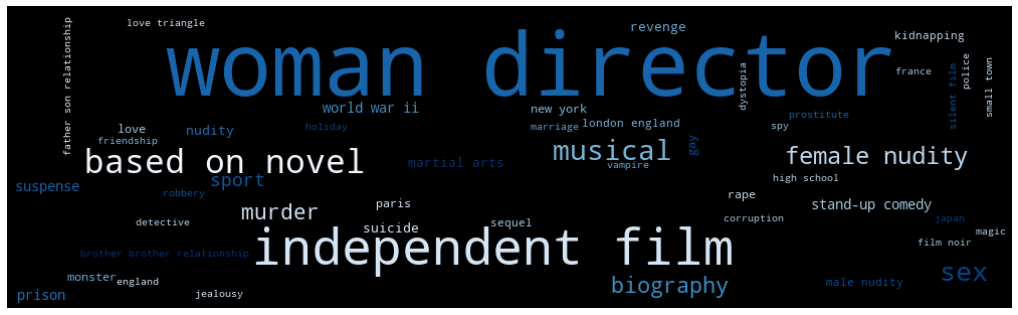

In [0]:
show_population(keywords, 'WC')

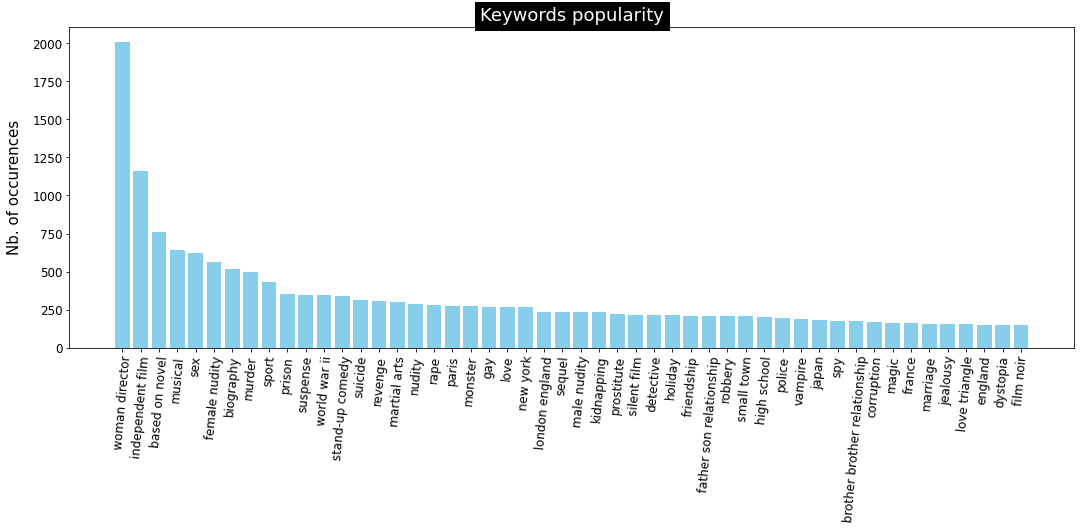

In [0]:
show_population(keywords, 'HG')

In [0]:
cast[:5]

[['John Wayne', 106],
 ['Jackie Chan', 89],
 ['Michael Caine', 86],
 ['Robert De Niro', 86],
 ['Gérard Depardieu', 84]]

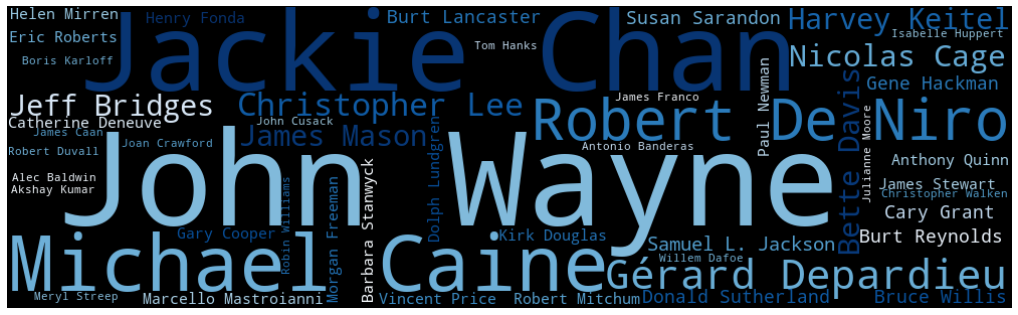

In [0]:
cast = count_word(df_movie, 'cast')
show_population(cast, 'WC')

We can see that John Wayne has higher population than Christopher even though in record Christopher Lee participate in more movie than John Wayne. This happens because we only get top 3 main characters from a movies for the model.

# Clean Data



In [0]:
df_movie[['title', 'cast', 'director', 'keywords', 'genres']]

title  ...                        genres
0                        Toy Story  ...   [Animation, Comedy, Family]
1                          Jumanji  ...  [Adventure, Fantasy, Family]
2                 Grumpier Old Men  ...             [Romance, Comedy]
3                Waiting to Exhale  ...      [Comedy, Drama, Romance]
4      Father of the Bride Part II  ...                      [Comedy]
...                            ...  ...                           ...
46620                       Subdue  ...               [Drama, Family]
46621          Century of Birthing  ...                       [Drama]
46622                     Betrayal  ...     [Action, Drama, Thriller]
46623             Satan Triumphant  ...                            []
46624                     Queerama  ...                            []

[46625 rows x 5 columns]

We are going to remove all space, lowercase all characters

In [0]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    return str.lower(x.replace(" ", ""))

for col in ['cast', 'keywords', 'director', 'genres']:
    df_movie[col] = df_movie[col].apply(clean_data)

Create "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() to convert a collection of text documents to a matrix of token counts instead of TF-IDF. 

This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [0]:
def create_soup(x):
    soup = ""
    if len(x['keywords']) > 0:
      soup += ' '.join(x['keywords']) + ' '
    if len(x['cast']) > 0:
      soup += ' '.join(x['cast']) + ' '
    soup += x['director'] + ' '
    if len(x['genres']) > 0:
      soup += ' '.join(x['genres'])
    return soup
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

df_movie['soup'] = df_movie.apply(create_soup, axis=1)
count_matrix = CountVectorizer(stop_words='english').fit_transform(df_movie['soup'])
count_matrix.shape

(46625, 73879)

# Get similar movies
Because of the memory capicity, we are going to compute the 
Cosine Similarity for a movie by getting the movie vector and calculate cosine against other movies

In [0]:
df_movie = df_movie.reset_index()
indices = pd.Series(df_movie.index, index=df_movie['title'])

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
def _top_similar_movie(m_name, df, sim_matrix):
    idx = df[df.title == m_name].index[0]
    sim_scores = cosine_similarity(sim_matrix[idx], sim_matrix)[0]
    movie_indices = sorted(range(len(sim_scores)), key=lambda i: sim_scores[i], 
                           reverse=True)[:11]
    if idx not in movie_indices:
        movie_indices.append(idx)
    top10 = df.iloc[movie_indices]
    for index, row in top10.iterrows():
        print(row.title)
    return top10
def get_top10_similar_movies(m_name):
  _top_similar_movie(m_name, df_movie, sim_matrix=count_matrix)

In [0]:
get_top10_similar_movies('Skyfall')

Skyfall
Spectre
Quantum of Solace
Behind Enemy Lines
Evil Behind You
The Venetian Affair
Triple Cross
Arabesque
Mission: Impossible
Tomorrow Never Dies
Never Say Never Again


We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. 

It is more likely that Action movie fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

# Part 3: Recommendation movies for an user

**What movies which an user will like?**

The movies have the similar attributes to the movie the user watched and liked before
The movies that someone like who has similar movie ratings record to the user

**Data Resource**

Rating dataset: contains 100,000 ratings from 700 users on 9,000 movies

**What is Collaborative Filtering?**

Collaborative filtering (CF) systems and computer-based recommendation are often related with the origin of the system called Tapestry. In Tapestry, with arbitrary text comments users were able to annotate documents and other users based on the comments of other users could then query. One of the main attributes of this system is that it allowed recommendations to be generated based on a combination of ideas of the input from many other users. Rather than 

**Solution**

**User based filtering**- These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity.

**Item Based Collaborative Filtering** - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. This method faces an issue of scalability when there are large number of users and items


**Single Value Decomposition**
One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.


In [0]:
#!pip install scikit-surprise

# Load data

In [0]:
from surprise import Reader, Dataset, SVD
reader = Reader()
df_ratings = pd.read_csv('ratings_small.csv')
df_ratings.head(5)

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [0]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


There is no null data in this dataset. Let's take a look at the distribution.

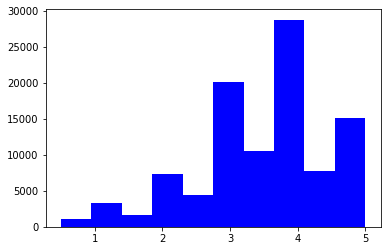

In [0]:
ax = plt.hist(df_ratings.rating, color='blue')

# SVD training model

Here are the average RMSE, MAE and total execution time of various algorithms (with their default parameters) on a 5-fold cross-validation procedure. The datasets are the Movielens 100k and 1M datasets. The folds are the same for all the algorithms. All experiments are run on a notebook with Intel Core i5 7th gen (2.5 GHz) and 8G. The code for generating these tables can be found in the benchmark example.


<table>
<thead>
<tr>
<th align="left"><a href="http://grouplens.org/datasets/movielens/100k" rel="nofollow">Movielens 100k</a></th>
<th align="right">RMSE</th>
<th align="right">MAE</th>
<th align="left">Time</th>
</tr>
</thead>
<tbody>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD" rel="nofollow">SVD</a></td>
<td align="right">0.934</td>
<td align="right">0.737</td>
<td align="left">0:00:11</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp" rel="nofollow">SVD++</a></td>
<td align="right">0.92</td>
<td align="right">0.722</td>
<td align="left">0:09:03</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF" rel="nofollow">NMF</a></td>
<td align="right">0.963</td>
<td align="right">0.758</td>
<td align="left">0:00:15</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/slope_one.html#surprise.prediction_algorithms.slope_one.SlopeOne" rel="nofollow">Slope One</a></td>
<td align="right">0.946</td>
<td align="right">0.743</td>
<td align="left">0:00:08</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBasic" rel="nofollow">k-NN</a></td>
<td align="right">0.98</td>
<td align="right">0.774</td>
<td align="left">0:00:10</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNWithMeans" rel="nofollow">Centered k-NN</a></td>
<td align="right">0.951</td>
<td align="right">0.749</td>
<td align="left">0:00:10</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline" rel="nofollow">k-NN Baseline</a></td>
<td align="right">0.931</td>
<td align="right">0.733</td>
<td align="left">0:00:12</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/co_clustering.html#surprise.prediction_algorithms.co_clustering.CoClustering" rel="nofollow">Co-Clustering</a></td>
<td align="right">0.963</td>
<td align="right">0.753</td>
<td align="left">0:00:03</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly" rel="nofollow">Baseline</a></td>
<td align="right">0.944</td>
<td align="right">0.748</td>
<td align="left">0:00:01</td>
</tr>
<tr>
<td align="left"><a href="http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor" rel="nofollow">Random</a></td>
<td align="right">1.514</td>
<td align="right">1.215</td>
<td align="left">0:00:01</td>
</tr>
</tbody>
</table>

So we choose SVD for our API

In [0]:
from surprise.model_selection import cross_validate
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
trainset = data.build_full_trainset()
svd.fit(trainset)
testset = trainset.build_anti_testset()
predictions = svd.test(testset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8987  0.8939  0.9001  0.9005  0.8910  0.8969  0.0038  
MAE (testset)     0.6881  0.6903  0.6921  0.6919  0.6882  0.6901  0.0017  
Fit time          4.88    4.94    4.95    4.95    4.93    4.93    0.03    
Test time         0.75    0.15    0.15    0.15    0.15    0.27    0.24    


# Generate the top 10 recommendation movies for an user

In [0]:
from collections import defaultdict
def get_top_n(predictions, n=20):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top10_svd = get_top_n(predictions)

def _top10_recommend(user_id, df):
    movie_indices = []
    ids = df.id.unique()
    for movie_id, rating in top10_svd[user_id]:
        # print(movie_id, rating)
        if movie_id in ids:
            movie_indices.append(df[df.id == movie_id].index[0])
    return df.iloc[movie_indices]

def top10_recommend(user_id):
    top10 = _top10_recommend(user_id, df_movie)
    return top10


# Pick an user for example

In [0]:
#userID = 1
df=top10_recommend(1)
columns=['id', 'title']
df[columns]

id                     title
952     260              The 39 Steps
534     858      Sleepless in Seattle
4047    318  The Million Dollar Hotel
11590  1259        Notes on a Scandal
2674    745           The Sixth Sense
286     527        Once Were Warriors
8399    905             Pandora's Box
34127  3578                The Tunnel
22544  5995                     Miffo
3409    593                   Solaris
2085   4011               Beetlejuice
3085    926              Galaxy Quest

# Part 4: API and UI webapp

**Recommendation System API:**

VM - EC2 instance - 4cpu and 16 GB

Dockerfile:

```
FROM python:3.7

COPY ./requirements.txt /app/requirements.txt
WORKDIR /app
RUN pip install -r requirements.txt
ENTRYPOINT [ "python" ]
CMD [ "app/main.py" ]
```

http://ec2-18-222-249-229.us-east-2.compute.amazonaws.com:5000/

**UI Webapp:**

Dockerfile:

```
# base image
FROM node:12.2.0-alpine

# set working directory
WORKDIR /app

# add `/app/node_modules/.bin` to $PATH
ENV PATH /app/node_modules/.bin:$PATH

# install and cache app dependencies
COPY package.json /app/package.json
RUN npm install
RUN npm install @vue/cli@3.7.0 -g

# start app
CMD ["npm", "run", "serve"]
```

http://ec2-18-222-249-229.us-east-2.compute.amazonaws.com:8081/

**Code:**

https://github.com/votamvan/Movie-Recommendation



# Top Trending Movies - based on popularity

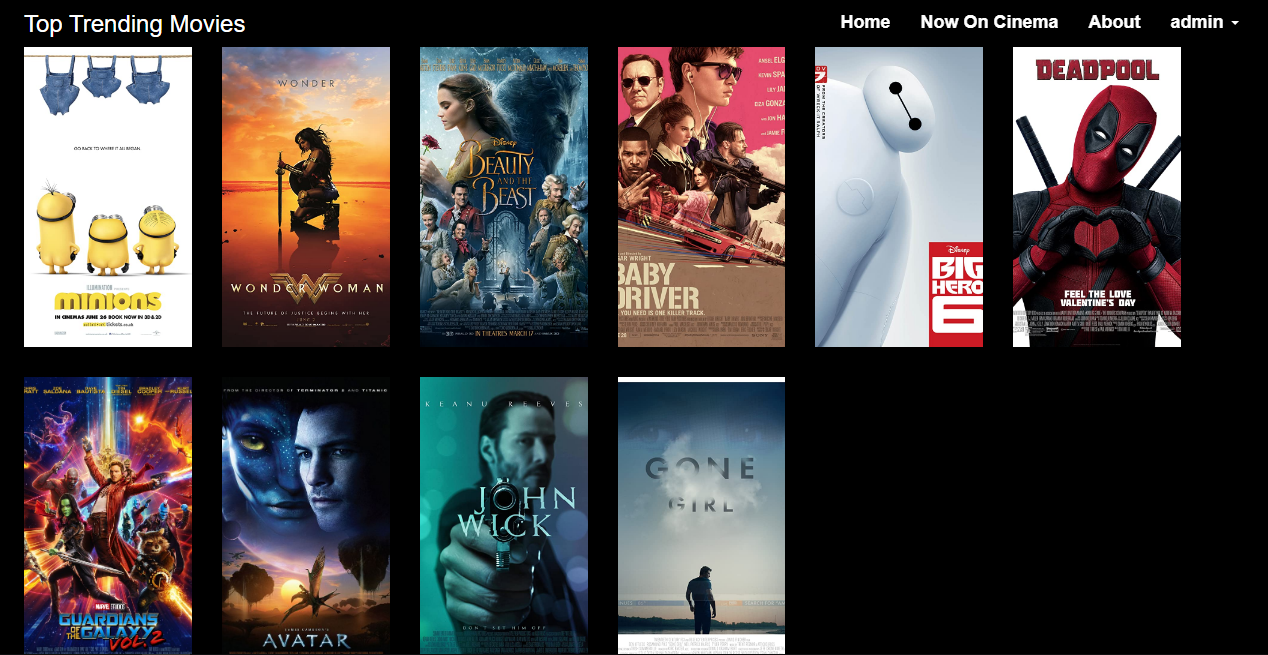

# Top recommendations for an user - ID **44**

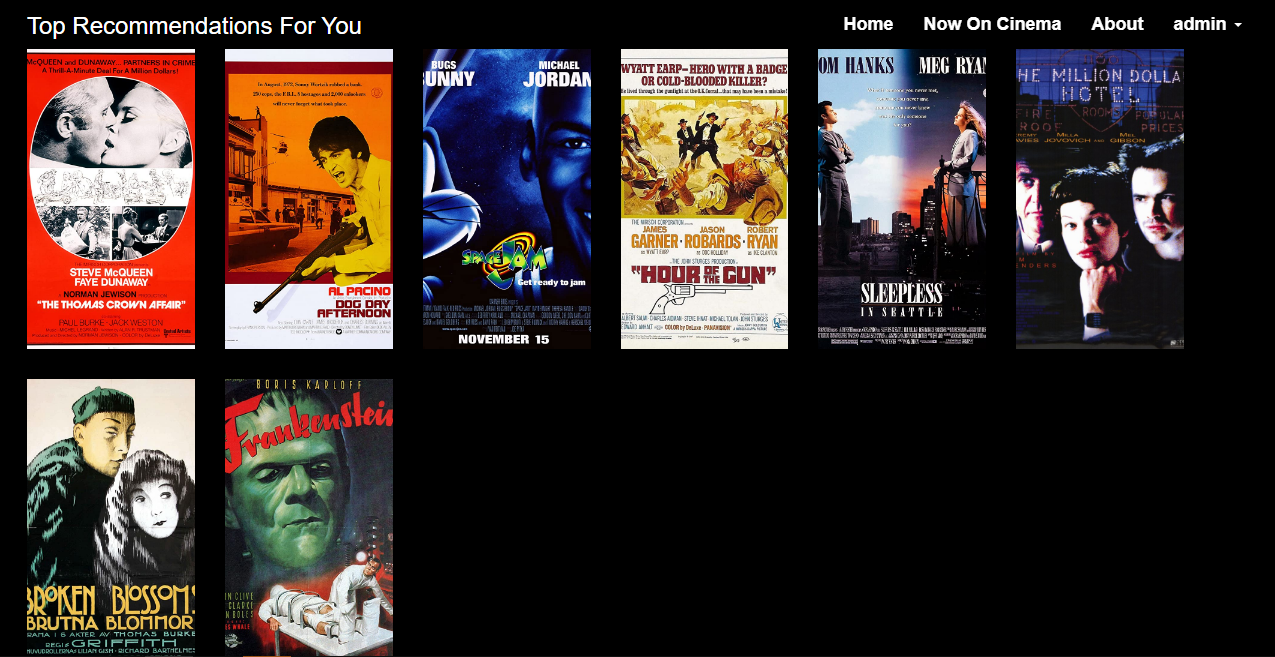

# Recommend similar movies

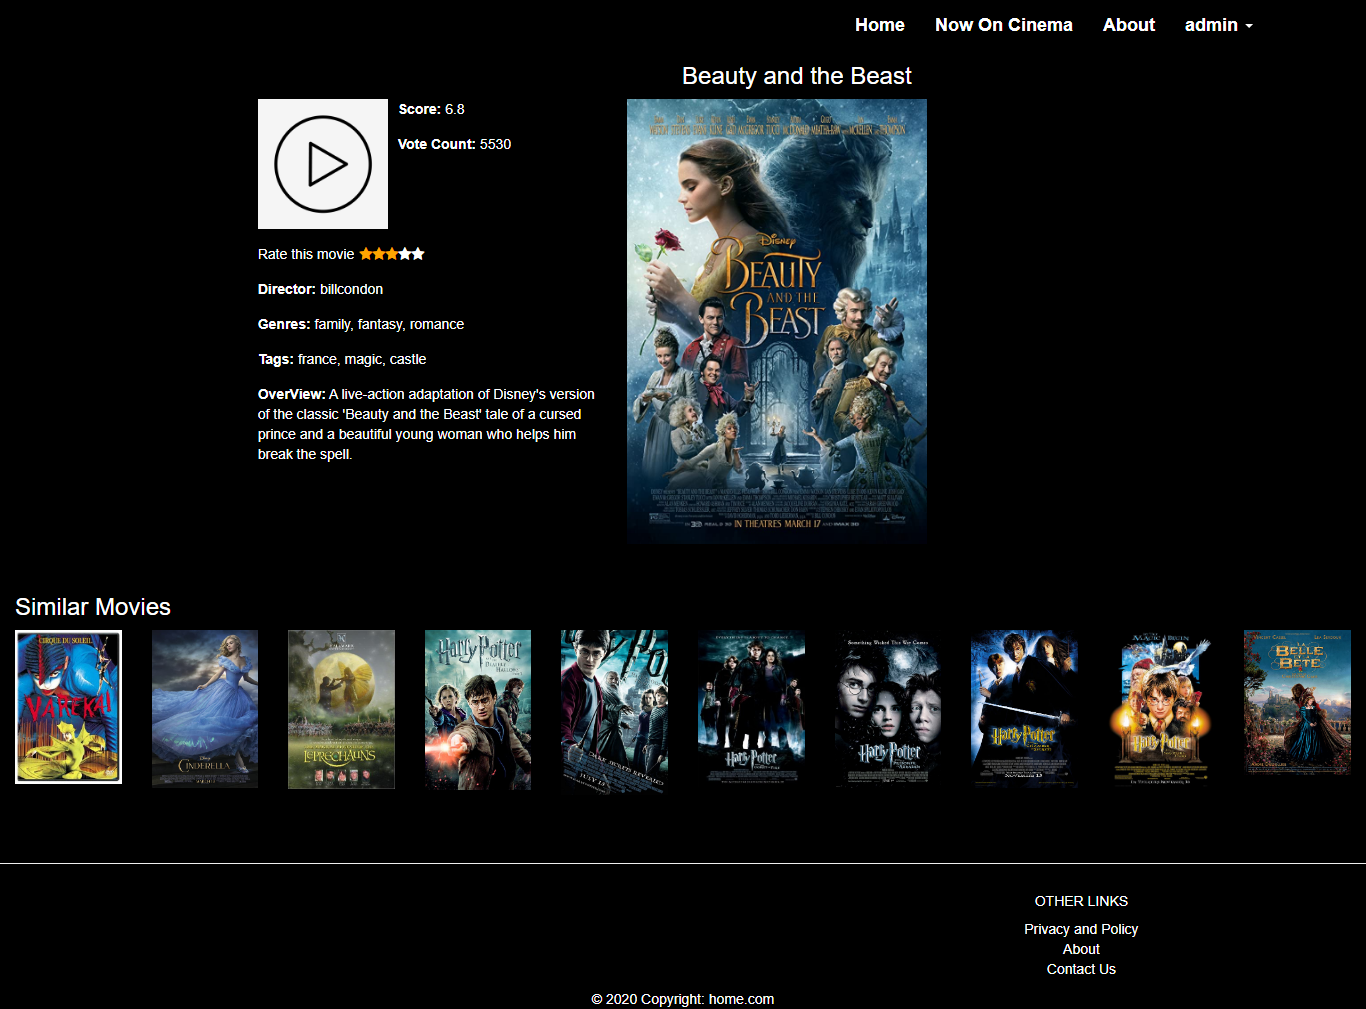

# Calling to API through Notebook

In [0]:
import requests
 
BASE_URL = "http://ec2-18-222-249-229.us-east-2.compute.amazonaws.com:5000/api/v0/"
TOP_TREND_URL = BASE_URL + "toptrending/us"
 
r = requests.post(TOP_TREND_URL)
r.json()

{'data': [{'director': 'kylebalda',
   'genres': ['family', 'animation', 'adventure'],
   'imdb_id': 'tt2293640',
   'keywords': ['assistant', 'aftercreditsstinger', 'duringcreditsstinger'],
   'movieId': 211672,
   'overview': 'Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world.',
   'score': 6.4,
   'title': 'Minions',
   'url': 'https://raw.githubusercontent.com/votamvan/Movie-Recommendation/master/movie-posters/tt2293640.jpg',
   'vote_average': 6.4,
   'vote_count': 4729.0},
  {'director': 'pattyjenkins',
   'genres': ['action', 'adventure', 'fantasy'],
   'imdb_id': 'tt0451279',
   'keywords': ['dccomics', 'hero', 'greekmythology'],
   'movieId': 297762,
   'overview': 'An Amazon princess comes to the world of Man to become the greatest of the female superheroes.',
   'score': 7.2,
   'title': 'Wonder Woman',
   'url': 'https://raw.githubusercontent.com/votamvan/Movie-Rec

# Part 5: AUTOML (NCF)

**Research:**

https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401

**Tried running demo:**

https://github.com/hexiangnan/neural_collaborative_filtering

Experiment with MovieLens 1M Dataset, it tooks 4-5 hours to train on local CPU machine. If we have GPU machine, the training time may be reduced.

Although, the accuracy of NCF model is a little bit better than SVD algorithm. However, we choose SVD to be implemented as our API recommendation engine.

We have to trade off between fast API responses and the movie prediction performance. SVD is the best selection for industry business.

**Output log file:**

https://github.com/votamvan/Movie-Recommendation/blob/master/auto-ncf-log.txt



```
GMF arguments: Namespace(batch_size=256, dataset='ml-1m', epochs=20, learner='adam', lr=0.001, num_factors=8, num_neg=4, out=1, path='Data/', regs='[0,0]', verbose=1)
Load data done [28.0 s]. #user=6040, #item=3706, #train=994169, #test=6040
Init: HR = 0.0962, NDCG = 0.0434     [12.4 s]
.
.
.
End. Best Iteration 16:  HR = 0.6361, NDCG = 0.3647. 

MLP arguments: Namespace(batch_size=256, dataset='ml-1m', epochs=20, layers='[64,32,16,8]', learner='adam', lr=0.001, num_neg=4, out=1, path='Data/', reg_layers='[0,0,0,0]', verbose=1) 
Load data done [30.3 s]. #user=6040, #item=3706, #train=994169, #test=6040
Init: HR = 0.0964, NDCG = 0.0442 [17.1]
.
.
.
End. Best Iteration 14:  HR = 0.6752, NDCG = 0.3995. 

NeuMF arguments: Namespace(batch_size=256, dataset='ml-1m', epochs=20, layers='[64,32,16,8]', learner='adam', lr=0.001, mf_pretrain='Pretrain/ml-1m_GMF_8_1501651698.h5', mlp_pretrain='Pretrain/ml-1m_MLP_[64,32,16,8]_1501652038.h5', num_factors=8, num_neg=4, out=1, path='Data/', reg_layers='[0,0,0,0]', reg_mf=0, verbose=1) 
Load data done [27.4 s]. #user=6040, #item=3706, #train=994169, #test=6040
Load pretrained GMF (Pretrain/ml-1m_GMF_8_1501651698.h5) and MLP (Pretrain/ml-1m_MLP_[64,32,16,8]_1501652038.h5) models done. 
Init: HR = 0.6710, NDCG = 0.3969
.
.
.
End. Best Iteration 2:  HR = 0.6823, NDCG = 0.4034. 
```

